### Модель восстановления значения потребления энергоресурса

Модель восстанавливать значение **Y** - потребление энергоресурса на основе известных значений **X**  в текущий момент времени. На вход модели в момент времени **t** *(момент расчета таргета)* должен передаваться набор данных, известных на момент **t**. 

## План решения
**Подготовка данных**
* Поиск пропусков, аномальных значений
* Изменение типа данных
* Проверка дубликатов
* Оценка мультиколлинеарности

**Построение модели**
* Разделение всего набора данных на: `train`, `valid`, `test`
* Оценка качества на примере нескольких моделей, выбор наилучшей
* Оценка качества с использованием кросс-валидации
* Оценка качества при удалении аномальных значений признаков

**Вывод**

In [1]:
import pandas as pd
import datetime
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

In [2]:
pd.set_option('display.max_columns', None) # добавление свойства для отображения всех столбцов датасета

Загрузка данных

In [3]:
DIR_NAME = '../power_consumption/power.csv/'

data = pd.read_csv(os.path.dirname(DIR_NAME))
data.sample(5, random_state=5)

,date,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,y
27,2020-05-17 11:59:59.999,419.521218,472.166470,495.458553,1.032334,1165.802270,481.968189,418.056313,524.238768,10.895871,483.096218,425.014273,847.700012,12.918750,499.166925,987.651316,17.041739,-0.708409,89.583471,489.995344,487.923737,458.617785,92.358746,480.374073,427.926922,446.636614,328.614729,476.708783,518.926196,95.880390,494.789768,25.673900
1482,2020-07-17 02:59:59.999,419.050686,471.654070,526.174203,0.769393,1127.893903,488.568656,424.783816,529.725895,10.927166,475.557783,435.521795,847.700012,12.504233,484.031817,952.445995,17.748742,-1.177112,89.522599,506.719783,486.222899,406.003124,96.672921,483.246670,423.960077,451.838530,330.573559,492.157192,510.746570,94.865690,470.073775,24.710737
3021,2020-09-19 05:59:59.999,397.662180,449.002566,476.618982,0.856954,1044.845823,469.214219,436.964310,500.007729,10.644802,456.523268,446.581079,846.001957,12.037886,463.256213,882.100492,18.935980,-1.912899,88.726218,492.391354,490.554693,408.998846,89.984484,490.052259,403.540191,457.395477,325.123785,480.887842,497.045047,93.737928,457.657023,24.239104
3867,2020-10-24 11:59:59.999,428.707191,489.437703,507.437076,1.096236,1158.736562,496.492714,430.615527,545.328387,10.729972,480.866360,434.370992,847.023179,12.687693,496.498052,982.137167,17.893613,-2.619912,90.001581,514.122871,504.751928,412.189073,92.012164,484.633097,437.852228,450.105045,326.899233,524.779736,525.171862,94.979463,513.302815,26.902051
637,2020-06-11 21:59:59.999,417.727198,458.302068,497.823681,0.816807,1158.836229,490.342336,431.752165,512.745146,10.824109,491.636793,438.277974,847.700012,12.137263,483.362940,974.443991,18.117581,-1.861261,93.839134,494.713850,494.859116,407.768378,94.805807,497.740657,423.439944,433.145333,329.091775,467.170533,497.562878,97.615598,491.512867,24.706021


На слуайном наборе данных не обнаружено пропусков или аномальных значений. Осуществим проверку типов и пропуски в данных по всему набору

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 32 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    5000 non-null   object 
 1   x1      5000 non-null   float64
 2   x2      5000 non-null   float64
 3   x3      5000 non-null   float64
 4   x4      5000 non-null   float64
 5   x5      5000 non-null   float64
 6   x6      5000 non-null   float64
 7   x7      5000 non-null   float64
 8   x8      5000 non-null   float64
 9   x9      5000 non-null   float64
 10  x10     5000 non-null   float64
 11  x11     5000 non-null   float64
 12  x12     5000 non-null   float64
 13  x13     5000 non-null   float64
 14  x14     5000 non-null   float64
 15  x15     5000 non-null   float64
 16  x16     5000 non-null   float64
 17  x17     5000 non-null   float64
 18  x18     5000 non-null   float64
 19  x19     5000 non-null   float64
 20  x20     5000 non-null   float64
 21  x21     5000 non-null   float64
 22  

Пропуски отсутсвуют - не придется заполнять недостающие значения (например: медианой или средним значением). Все признаки `x` и целевой признак `y` имеют имеют формат `float64`, а вот формат столбца `date` можно заменить

#### Подготовка данных

In [5]:
data['date'].sample(5, random_state=5)

27      2020-05-17 11:59:59.999
1482    2020-07-17 02:59:59.999
3021    2020-09-19 05:59:59.999
3867    2020-10-24 11:59:59.999
637     2020-06-11 21:59:59.999
Name: date, dtype: object

In [6]:
data['date'].head(3)

0    2020-05-16 08:59:59.999
1    2020-05-16 09:59:59.999
2    2020-05-16 10:59:59.999
Name: date, dtype: object

Лучше время округлить до целого часа, `11:59:59.999`  скорее всего получение значений признаков происходит в конце каждого часа. Дискретность значений 1 час. Оценим другие минутные интервалы, чтобы убедиться в правильном выводе о дисректности получаемых значений в 1 час  

In [7]:
data['date'] = pd.to_datetime(data['date'], unit='ns')
data['date'].dt.minute.value_counts()

59    4449
0      551
Name: date, dtype: int64

Минут или `59` или `0`. Можно округлить значения до полного часа

In [8]:
data['date'] = pd.to_datetime(data['date'], unit='ns').round('H')
data['date'].sample(5, random_state=5)

27     2020-05-17 12:00:00
1482   2020-07-17 03:00:00
3021   2020-09-19 06:00:00
3867   2020-10-24 12:00:00
637    2020-06-11 22:00:00
Name: date, dtype: datetime64[ns]

In [9]:
data['date_timestamp'] = data['date'].apply(lambda x: x.timestamp())
data['date_timestamp'].sample(5,random_state=5)

27      1.589717e+09
1482    1.594955e+09
3021    1.600495e+09
3867    1.603541e+09
637     1.591913e+09
Name: date_timestamp, dtype: float64

Посмотрим за какой период у нас в наборе данные: с середины мая по начала декабря 2020 года

In [10]:
data['date'].dt.month.value_counts()

8     744
10    744
7     744
9     720
6     720
11    719
5     375
12    234
Name: date, dtype: int64

**Получение основных статистических данных набора**

In [11]:
data.describe()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,y,date_timestamp
count,5000.000000,5000.000000,5000.000000,5.000000e+03,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5.000000e+03,5.000000e+03
mean,412.558413,466.191270,498.542159,1.150161e+00,1122.376617,487.107482,427.268146,522.531333,10.771032,474.921944,437.188157,845.384887,12.116188,487.326765,947.713623,18.096655,-1.557630,88.215716,496.087235,495.096268,415.160333,91.382642,482.137038,417.463349,451.948018,326.589842,494.145909,509.917971,93.591592,482.768671,-1.833924e+34,1.598618e+09
std,31.618688,17.762825,14.515954,9.285411e-01,35.714308,7.790535,10.746298,16.922701,0.130060,8.964280,9.824390,2.769118,0.611200,16.335426,30.638035,0.484207,1.230254,5.270452,10.606391,16.123912,12.897657,6.652589,12.480993,46.146322,8.490221,2.558371,15.212624,15.227448,5.187918,20.775683,7.221883e+35,5.197122e+06
min,27.793140,409.172346,462.484312,6.119388e-11,998.123018,461.205851,379.225705,478.927232,10.137592,445.084616,389.885910,835.266682,7.626271,440.745949,841.220368,16.914644,-9.504106,72.959680,468.098316,445.342474,394.502810,73.968899,449.419110,15.514387,390.374057,318.882722,404.899015,473.508838,77.932461,446.752951,-3.872055e+37,1.589620e+09
25%,410.540760,455.096904,489.833896,8.990056e-01,1106.845483,482.463276,421.102176,509.576734,10.696950,469.779211,432.770493,843.502075,11.722349,476.779233,932.203913,17.795653,-2.351019,84.010595,490.120101,487.768242,407.623911,85.997821,473.553597,417.034060,448.272139,324.702249,483.388533,499.110743,90.999615,465.637417,2.408568e+01,1.594119e+09
50%,414.458905,464.713622,495.384221,9.986112e-01,1130.719522,487.291185,428.662999,522.186462,10.780310,475.030014,438.586752,846.370000,12.184724,485.852960,953.773138,18.020936,-1.406486,90.403457,496.274560,494.143981,410.973243,94.264830,483.340933,420.948190,452.806470,326.650623,490.565081,507.402927,95.575776,478.346238,2.463131e+01,1.598618e+09
75%,423.489260,479.137063,506.167696,1.126167e+00,1147.535469,492.254889,435.540503,533.072266,10.860712,479.538780,444.557009,847.700012,12.520860,497.461135,970.391316,18.456510,-0.686001,92.203988,502.714796,503.357555,416.556197,96.539508,490.426649,433.098795,457.659768,328.335283,506.289345,520.889804,97.062363,502.283305,2.594548e+01,1.603117e+09
max,436.268339,510.542173,545.054459,8.038391e+00,1192.557479,506.559040,446.716565,569.905794,11.675275,502.626968,458.492005,849.137257,13.764691,531.085847,1008.724390,19.222657,1.327076,98.613520,527.470754,536.745635,470.115624,102.805867,513.616271,446.119896,473.231904,333.392611,534.225759,543.211897,102.687414,528.846750,2.868602e+01,1.607620e+09


In [12]:
print('Процент строк с аномальными значениями целевого признака:', data.query('y < 0').shape[0] / len(data.y) * 100)

Процент строк с аномальными значениями целевого признака: 0.1


Удалим эти строки из данных

In [13]:
data = data.drop(index=data.query('y < 0').index)

Поиск дуликатов в данных - не найдены

In [14]:
data[data.duplicated() == True].shape

(0, 33)

**Рассмотрение значения признаков на предмет аномальных значений**

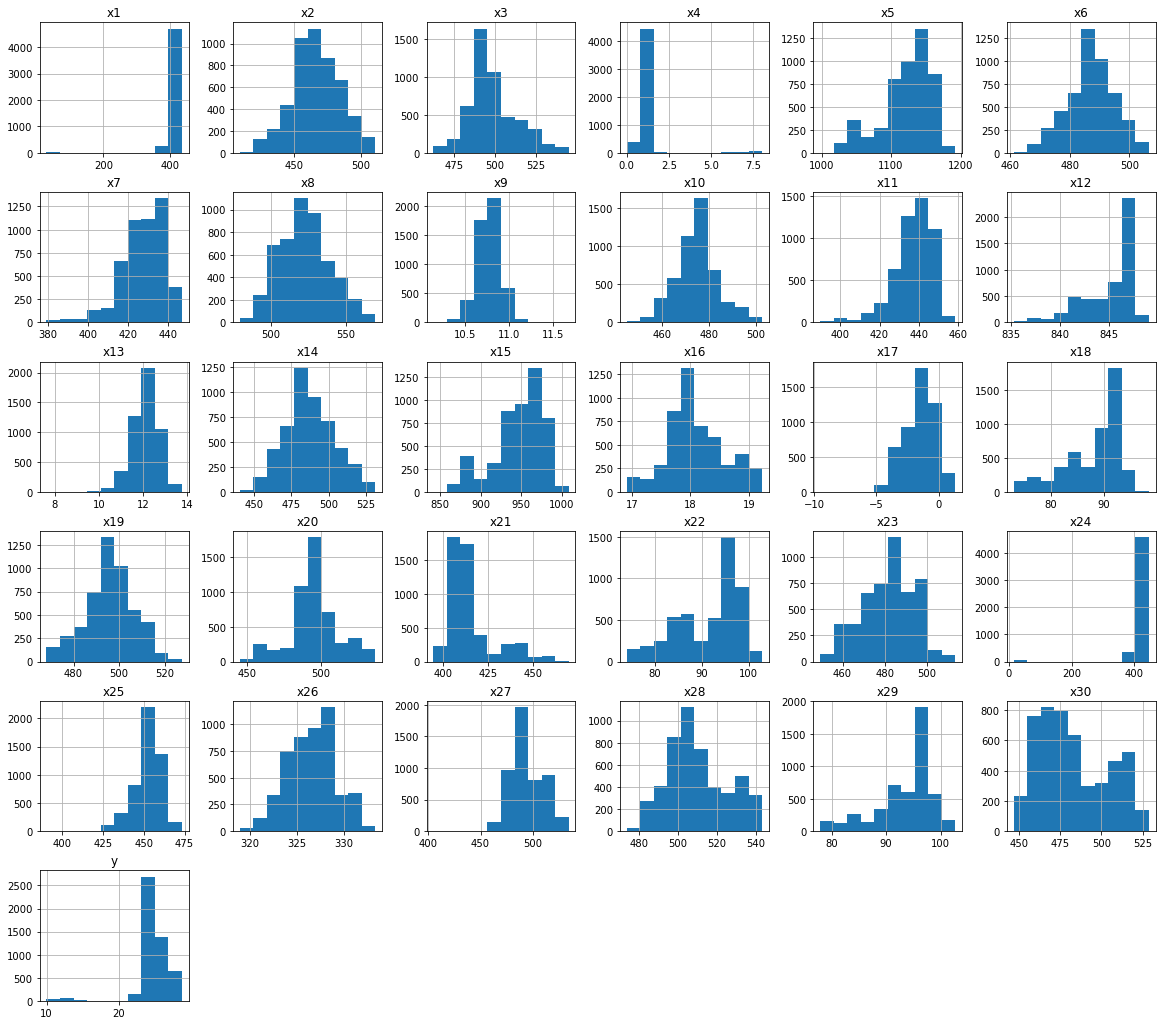

In [15]:
data.loc[:, data.columns[1:-1]].hist(figsize=(20, 18));

Большая часть признаков не имеет аномалий, но часть значений признаков: `x1`, `x4`, `x13`, `x17`, `x24`, `x27` имеют выбросы в данных. Построим эти признаки, необходимо понять, что это - случайные события или повторяющиеся во времени процессы.

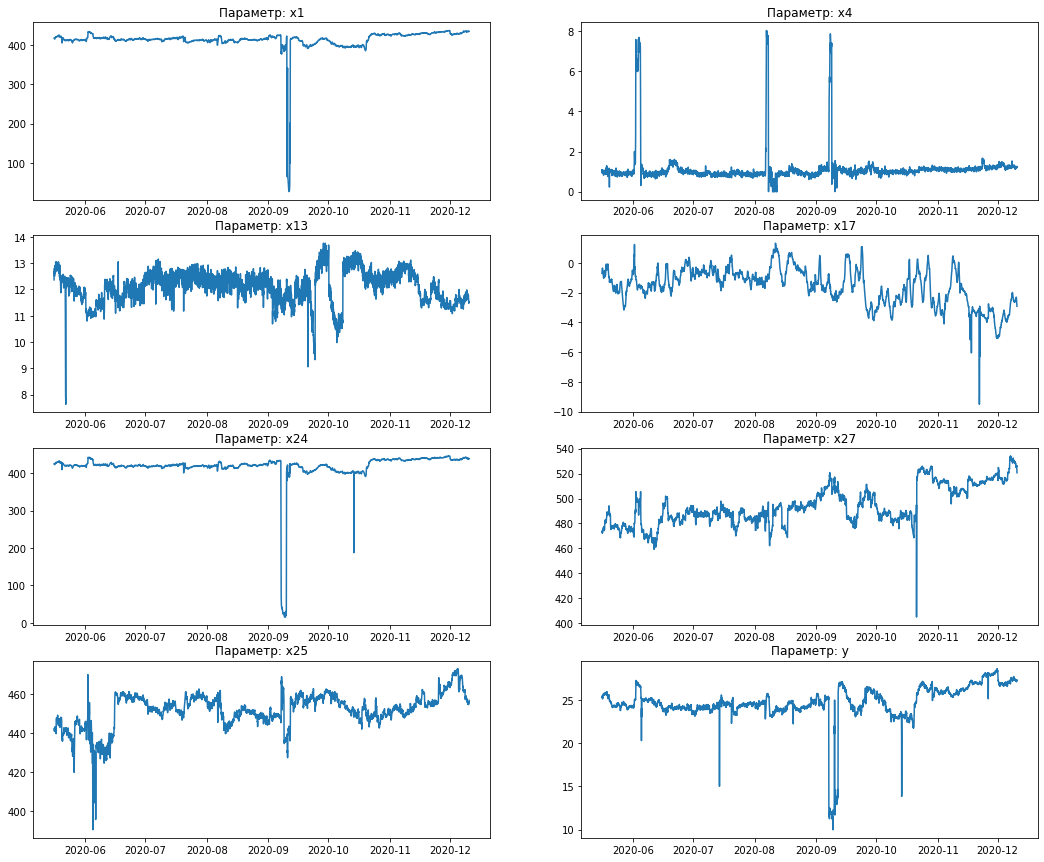

In [16]:
col_name = ['x1', 'x4', 'x13', 'x17', 'x24', 'x27', 'x25', 'y'] # список из интересующих параметров

fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(18, 15))
axs = axs.flatten()
for i in range(len(col_name)):
    axs[i].plot(data['date'], data[col_name[i]]);
    axs[i].set_title("Параметр: " + col_name[i])

Значение целевой функции - потребление энергоресурса(единиц измерения и прочих данных нет - нельзя понять вид ресурса), могу предположить, что признаки получены с приборов измерения или индикаторов. Однозначно утверждать, что это случайные выбросы (возможно авария, отключение или другие факторы отличные от нормального режима работы) нельзя - необходимо описание технологического процесса. У целевого признака также имеются выбросы, но снижения потребления до 0 не было. Оставим как есть. Параметры `x1` и `x24` очень похожи друг на друга, скорее всего коллинеарны.

Проверим ряд на стационарность. В стационарном ряду будущие статистические характеристики не будут отличаться от наблюдаемых текущих. Используем тест [Dickey-Fuller][3]

[3]: https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html?highlight=adfuller#statsmodels.tsa.stattools.adfuller

In [17]:
test = adfuller(data['y'])
print ('adf: ', test[0])
print ('p-value: ', test[1])
print ('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('единичных корней нет, ряд стационарен')

adf:  -4.99358816804956
p-value:  2.2850835576650104e-05
Critical values:  {'1%': -3.43166220814716, '5%': -2.862119853748156, '10%': -2.567078656914853}
единичных корней нет, ряд стационарен


Отлично, рад стационарен.

**Оценка мультиколлинеарности**

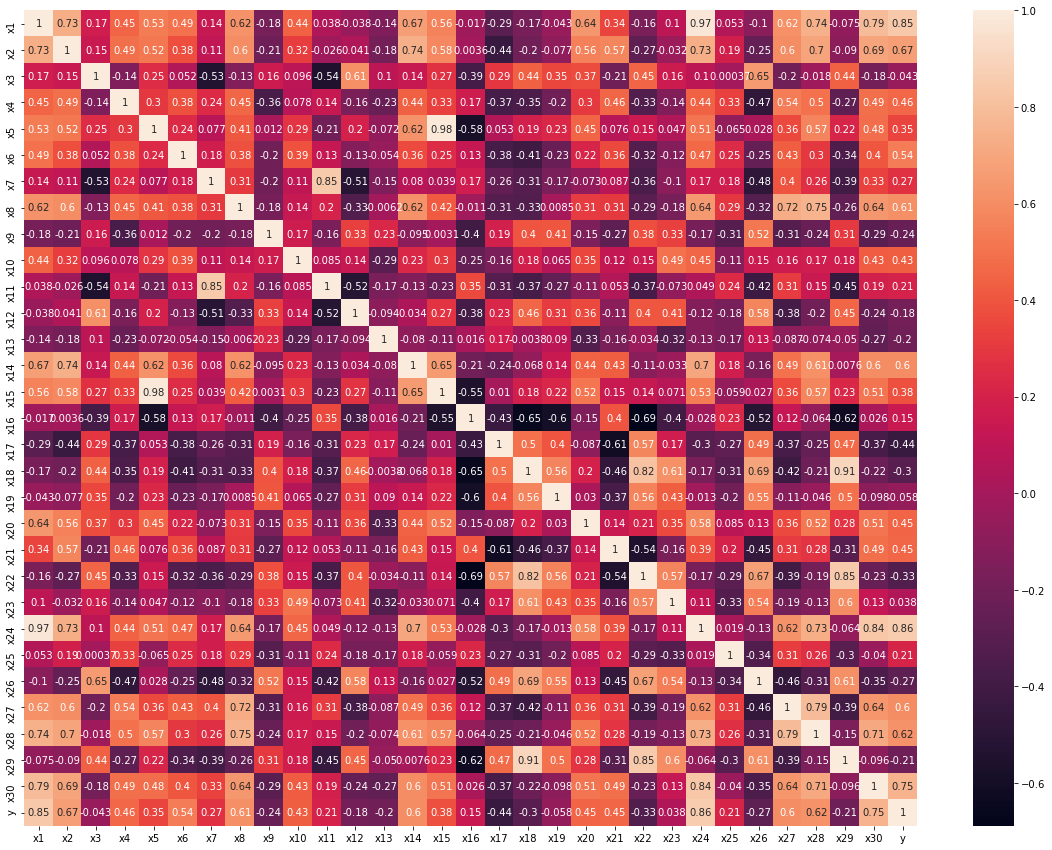

In [18]:
cols = data.columns[1:-1] # возьмем только колличественные признаки
fig, ax = plt.subplots(figsize=(20,15))
sns.heatmap(data[cols].corr(method='spearman'),
            annot=True,
            ax=ax);

Удалим из выборки столбцы `x1`, `x5`, `x29`, `x11` - имеют высокое значение корреляции со столбцами `x24`, `x15`, `x18`, `x7`, но при этом меньшее влияние на целевой признак - `y`

In [19]:
data = data.drop(columns=['x1', 'x5', 'x29', 'x11'])

#### Построение модели

Разобьем все данные на три выборки:
* `train` - выборка для обучения модели
* `valid` - выборка для проверки качества модели при подборе параметров
* `test` - выборка для оценки качества работы

In [20]:
train, valid, test = np.split(data.sample(frac=1, random_state=15), [int(.9*len(data)), int(.95*len(data))])
print(train.shape, valid.shape, test.shape)

(4495, 29) (250, 29) (250, 29)


In [21]:
columns_name = train.columns[1:-2].values

features_train = train.loc[:, columns_name]
target_train = train['y']
features_valid = valid.loc[:, columns_name]
target_valid = valid['y']
features_test = test.loc[:, columns_name]
target_test = test['y']

Построим несколько моделей и оценим на валидационной выборке качество, метрики: [MAPE][1], [R2_score][2], [MSE][3]

[1]: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_percentage_error.html?highlight=mape
[2]: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html?highlight=r2#sklearn.metrics.r2_score
[3]: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html

In [22]:
models = [LinearRegression(),
          RandomForestRegressor(),
          KNeighborsRegressor(),
          DecisionTreeRegressor(),
          Lasso(alpha=0.1),
          Ridge(alpha=0.1)]

for model in models:
    m = str(model)
    print(m)
    model.fit(features_train, target_train)
    print('MSE: ', mean_squared_error(target_valid, model.predict(features_valid)))
    print('MAPE: ', mean_absolute_percentage_error(target_valid, model.predict(features_valid)))
    print('R2: ', r2_score(target_valid, model.predict(features_valid)))
    print('')

LinearRegression()
MSE:  1.1925738584706076
MAPE:  0.024591822756152296
R2:  0.7274372996932077

RandomForestRegressor()
MSE:  0.09648033023332729
MAPE:  0.004572765043717066
R2:  0.9779494249784992

KNeighborsRegressor()
MSE:  0.017628769676881383
MAPE:  0.0036999048878097276
R2:  0.9959709455040552

DecisionTreeRegressor()
MSE:  0.07413430275819957
MAPE:  0.005177161702563514
R2:  0.9830566085264948

Lasso(alpha=0.1)
MSE:  1.2806889428182249
MAPE:  0.02435325328290405
R2:  0.707298601232764

Ridge(alpha=0.1)
MSE:  1.1925806300390693
MAPE:  0.02459138194308944
R2:  0.7274357520515483



Лучшие результат показали модели: `RandomForestRegressor()` и `KNeighborsRegressor()`

Попробуем изменить параметры модели для улучшения качества

#### KNeighborsRegressor()
`KNeighborsRegressor()` - изменим число `n_neighbors` от 1 до 10

In [23]:
k_model = 1
best_rezult = 0.01
for K in range(1, 11):
    model = KNeighborsRegressor(n_neighbors = K)
    model.fit(features_train, target_train)
    error = mean_absolute_percentage_error(target_valid, model.predict(features_valid))
    if error < best_rezult:
        best_rezult = error
        k_model = K
    print('MAPE при k =', K, ':', error)

MAPE при k = 1 : 0.0036832976828215466
MAPE при k = 2 : 0.003570032298064501
MAPE при k = 3 : 0.0038014069074071995
MAPE при k = 4 : 0.0037397828970715556
MAPE при k = 5 : 0.0036999048878097276
MAPE при k = 6 : 0.00386208801228904
MAPE при k = 7 : 0.004217019301215581
MAPE при k = 8 : 0.00423615338134039
MAPE при k = 9 : 0.004253583189892902
MAPE при k = 10 : 0.004277146826099914


Лучшая точность при `k=2`, проверим качество модели на тестовых данных

In [24]:
model_kn = KNeighborsRegressor(n_neighbors = k_model)
model_kn.fit(features_train, target_train)
print('Точность на тестовых данных:', mean_absolute_percentage_error(target_test, model_kn.predict(features_test)))

Точность на тестовых данных: 0.003546886719258823


Визуализируем полученные данные. Изобразим на одном графике целевой признак тестовых данных и предсказанных моделью

In [25]:
def scatter_plot(target_test, features_test, model_name):
# Функуция для визуализации тестовых данных и данных предсказаний модели
# target_test - целевые значения тестовых данных
# features_test - признаки тестовой выборки
# model_name - модель
    
    fig, axs = plt.subplots(figsize=(8, 5))
    plt.scatter(np.arange(len(target_test)), target_test, label='target');
    plt.scatter(np.arange(len(target_test)), model.predict(features_test), color='red', label='predict');
    axs.set_title('Модель: ' + str(model_name));
    axs.legend();

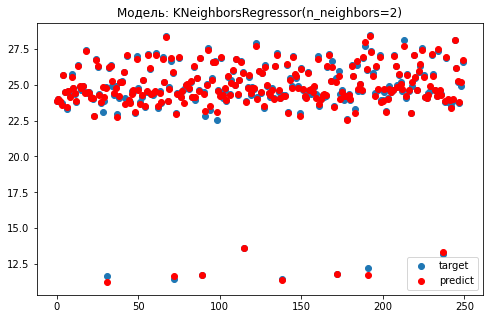

In [26]:
scatter_plot(target_test, features_test, model_kn)

#### RandomForestRegressor()

По умолчанию в моделе `n_estimators = 100`, на предварительной оценке такие параметры показали неплохой результат. Попробуем изменить `n_estimators` в этом диапазоне и посмотреть результат

In [27]:
best_model = None
best_result = 0.01
for est in range(99, 110):
    model = RandomForestRegressor(random_state=5, n_estimators=est)
    model.fit(features_train, target_train)
    result = mean_absolute_percentage_error(target_valid, model.predict(features_valid))
    if result < best_result:
        best_model = model
        best_result = result
print('MAPE:', best_result)
print("Параметры модели:", best_model)

model_rf = best_model
model_rf.fit(features_train, target_train)
print('Точность на тестовых данных:', mean_absolute_percentage_error(target_test, model_rf.predict(features_test)))

MAPE: 0.004665402394814398
Параметры модели: RandomForestRegressor(n_estimators=103, random_state=5)
Точность на тестовых данных: 0.0037548563421810426


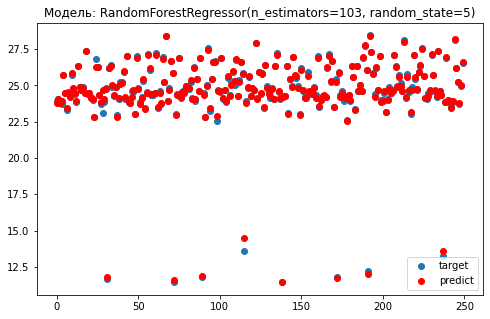

In [28]:
scatter_plot(target_test, features_test, model_rf)

#### Оценка качества кросс-валидацией

Разделим выборку на `train` и `test` в пропорции 75:25

In [29]:
features_train, features_test, target_train, target_test = train_test_split(data.loc[:, columns_name], 
                                                                            data['y'], test_size=0.25, random_state=42)

Функция для оценки качества `mean_absolute_percentage_error`

In [30]:
scorer = make_scorer(mean_absolute_percentage_error)

In [31]:
cross_val_score(KNeighborsRegressor(n_neighbors = 2), features_train, target_train, scoring=scorer, cv=5)

array([0.00515269, 0.00506882, 0.00492318, 0.00435147, 0.00603222])

In [32]:
cross_val_score(RandomForestRegressor(n_estimators=103), features_train, target_train, scoring=scorer, cv=5)

array([0.00457356, 0.00611646, 0.00539941, 0.00477223, 0.00755025])

In [33]:
models = [RandomForestRegressor(n_estimators=103),
          KNeighborsRegressor(n_neighbors = k_model)]

for model in models:
    m = str(model)
    print(m)
    model.fit(features_train, target_train)
    print('MSE: ', mean_squared_error(target_test, model.predict(features_test)))
    print('MAPE: ', mean_absolute_percentage_error(target_test, model.predict(features_test)))
    print('R2: ', r2_score(target_test, model.predict(features_test)))
    print('')

RandomForestRegressor(n_estimators=103)
MSE:  0.19716110172623047
MAPE:  0.0057162491055713196
R2:  0.9550929978515881

KNeighborsRegressor(n_neighbors=2)
MSE:  0.13455329876505095
MAPE:  0.004829986166197188
R2:  0.9693530558319345



Проверим какая будет точность модели, если удалить аномальные значения в признаке `x24`

In [34]:
x24_quantile = data['x24'].quantile(.99)
data = data.query('x24 >= @x24_quantile')

In [35]:
features_train, features_test, target_train, target_test = train_test_split(data.loc[:, columns_name], 
                                                                            data['y'], test_size=0.25, random_state=42)

In [36]:
cross_val_score(KNeighborsRegressor(n_neighbors = 2), features_train, target_train, scoring=scorer, cv=5).mean()

0.0022818986617923233

### Вывод

В нашем распоряжении оказались данные описывающие потребления энергоресурса в период с мая по декабрь 2020г. Вид энергоресурса, характеристика признаков в описании отсутствует - возможно данные со средств измерений и индикаторов. 

**Какие шаги были реализованы** 

Осуществлена предобработка данных, часть целевого признака имела аномальные отрицательные значения - были удалены. Осуществлен анализ мультиколлинеарности признаков: `x1`, `x5`, `x29`, `x11` (удалены из модели) - имеют высокое значение корреляции с признаками `x24`, `x15`, `x18`, `x7`.

Найдены аномальные выбросы в целевых признаках (не понятна природа выбросов), однако, значение целевого признака (потребления) до 0 значения не зафиксировано. Возможно это считается нормальным режимом работы, а выбросы зафисированы по отдельным средствам измерения.

В качестве моделей были использованы `LinearRegression, RandomForestRegressor, KNeighborsRegressor, DecisionTreeRegressor, Lasso , Ridge`. Наилучший результат показали модели: `RandomForestRegressor, KNeighborsRegressor`

В качестве метрик использовались: `MSE, MAPE, R2`.

При подборе параметров результаты были получены следующие: 
* KNeighborsRegressor(n_neighbors=2), MAPE_valid=0.00357, MAPE_test=0.0035
* RandomForestRegressor(n_estimators=103), MAPE_valid=0.00466, MAPE_test=0.0037

Значения метрики (MAPE) качества моделей на кросс-валидации следующие: 
* KNeighborsRegressor: MAPE_mean ~ 0.005
* RandomForestRegressor: MAPE_mean ~ 0.0056

Качество моделей снизилось по сравнению с предыдущим тестом - данный результат был ожидаемым. На кросс-валидации было больше тестовых данных, которые не знакомы модели. На передыдущем тесте число валидационных и тестовых данных было порядка 250 значений при числе деревьев в модели `model_rf` порядка `100`. При достаточно большой корреляции меджу признаками и тагретом модель нашла эти взаимосвязи и хорошо делала прогноз. 

В качестве теста, была проведена оценка MAPE при удаленных выбросах по признаку `x24`:
* KNeighborsRegressor(n_neighbors=2), MAPE_mean=0.00228 
качество улучшилось, но если окажется, что это нормальный режим потребления - модель будет хуже его прогнозировать.

В итоге для прогнозирования потребления энергоресурса на представленных данных лучше всего работает модель: `KNeighborsRegressor(n_neighbors=2) c качеством MAPE~0.005`

Возможные пути улучшения качества модели:
* не рассмотрено масштабирование признаков, но как указано ["Случайный лес"][4] не чувтсвителен к масштабированию
* сезонность изменения данных, получение новых признаков из даты и времени события

[4]: https://ru.wikipedia.org/wiki/Random_forest
